## Rough Notes
### Works pending in the notebook

- Clean the Data in Object type columns - RGN_NAME, AUTHC_SCNDRY_STAT_TXT, CUST_STATE, TRAN_TS,TRAN_DT, ACTVY_DT
- The transaction date - convert to age/days
- See if numbers are large and make sure using Logarthimc or similar functions
- In RGN_NAME, we have multiple missing values we can improve that by adding the regions using state data.
- Convert the date data into ages and see the effect
- Do Univariate, BiVariate analysis
- See the parameters that are good enough and remove the less affecting ones
- See the IP address state and Cust_state.
- Figure the classification modle based on probability threshold

### Exploration ideas

- Based on the knowledge, find the few features that would help in classifying at the start and make a scatter plot on that assumptions.
    Few things that can be done
    - Transaction Amount [In Bins] Vs Fraud/Non Fraud
    - Age [in bins] Vs Fraud/Non Fraud
    - RGN_name Vs Fraud/Non Fraud
    - ALERT_TRGR_CD Vs Fraud/Non Fraud
    - 
 
    

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel('trainset.xlsx')

# settings to display all columns
pd.set_option("display.max_columns", None)

# display the dataframe head
df.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,NaN,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,NaN,FACE_ID,ALLOW,94541,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,DESKTOP,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,SCHPMT,P2P_COMMIT,P2P,4/8/2021,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,MOBILE,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,SCHPMT,P2P_COMMIT,P2P,8/10/2021,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,MOBILE,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,SCHPMT,P2P_COMMIT,P2P,6/27/2021,Fraud


In [113]:
import matplotlib
print(matplotlib. __version__)

3.4.2


In [114]:
df['TRAN_TYPE_CD'].unique()

array(['P2P'], dtype=object)

In [115]:
#Understanding the missing values

df.isnull().sum()



TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
PWD_UPDT_TS                3125
CARR_NAME                  2709
RGN_NAME                   2709
STATE_PRVNC_TXT            2709
ALERT_TRGR_CD                 0
DVC_TYPE_TXT               1761
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT        74
CUST_ZIP                      0
CUST_STATE                   36
PH_NUM_UPDT_TS             7061
CUST_SINCE_DT                 0
TRAN_TS                       0
TRAN_DT                       0
ACTN_CD                       0
ACTN_INTNL_TXT                0
TRAN_TYPE_CD                  0
ACTVY_DT                      0
FRAUD_NONFRAUD                0
dtype: int64

In [116]:
df['ACTVY_DT'] = pd.to_datetime(df['ACTVY_DT'])
df['TRAN_DT'] = pd.to_datetime(df['TRAN_DT'])

#Creating a new columns for days in between transaction and activity

days_transaction_activity = df['ACTVY_DT'] - df['TRAN_DT']

days_transaction_activity.unique()



array([0], dtype='timedelta64[ns]')

> The above code shows that the activity date and transaction date are same days hence, we can drop either of them and look for seasonal activity by shifting them to categorical data.

In [117]:
#Updating NaN values of PWD_UPDT_TS, CARR_NAME, 

df['PWD_UPDT_TS'] = df['PWD_UPDT_TS'].fillna('Not_updated')
df['CARR_NAME'] = df['CARR_NAME'].fillna('No_Carrier')


#Filling the missing information with 'Not Updated' string in PH_NUM_UPDT_TS column!

df['PH_NUM_UPDT_TS'] = df['PH_NUM_UPDT_TS'].fillna('Not_updated')

#Device Type can be omitted as same data come from Alert Trigger code

df = df.drop(columns = 'DVC_TYPE_TXT')

# dropping the ACTVY_DT column

df = df.drop(columns = 'ACTVY_DT')



#Editing the null values on AUTHC_SCNDRY_STAT_TXT column.
df['AUTHC_SCNDRY_STAT_TXT'] = df['AUTHC_SCNDRY_STAT_TXT'].fillna('No_Secondary_Mgmnt')

df

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,2021-05-03,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,1/13/2021 19:19:37,2021-01-13,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,2021-04-08,SCHPMT,P2P_COMMIT,P2P,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,2021-08-10,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,2021-06-27,SCHPMT,P2P_COMMIT,P2P,Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,Not_updated,cellco partnership dba verizon wireless,southwest,california,MOBL,UN_PWD,ALLOW,92503,CA,7/15/2017 6:58:59,2001-06-05,3/12/2021 12:11:59,2021-03-12,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
13996,114.38,0.00,44,10,272,11/2/2017 4:28:20,t-mobile usa inc.,southwest,california,MOBL,FACE_ID,ALLOW,80478,CO,Not_updated,2010-06-03,6/11/2021 9:28:20,2021-06-11,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
13997,493.00,2848.63,54,3,517,6/3/2021 19:31:15,att services inc,southwest,california,MOBL,UN_PWD,ALLOW,33579,FL,5/25/2021 8:50:5,1984-10-27,5/16/2021 12:31:15,2021-05-16,SCHPMT,P2P_COMMIT,P2P,Fraud
13998,491.64,3163.25,21,3,0,3/2/2020 11:34:54,No_Carrier,NaN,NaN,ONLN,UN_PWD,ALLOW,91702,CA,Not_updated,2021-03-01,5/11/2021 12:34:54,2021-05-11,SCHPMT,P2P_COMMIT,P2P,Fraud


In [118]:
# Converting TRAN_TS = date_time

df['TRAN_TS'] = pd.to_datetime(df['TRAN_TS'])
 
df['TRAN_TS'] = (df['TRAN_TS'].dt.hour % 24 + 4) // 4

df

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,5,2021-05-03,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,5,2021-01-13,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,3,2021-04-08,SCHPMT,P2P_COMMIT,P2P,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,4,2021-08-10,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,3,2021-06-27,SCHPMT,P2P_COMMIT,P2P,Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,Not_updated,cellco partnership dba verizon wireless,southwest,california,MOBL,UN_PWD,ALLOW,92503,CA,7/15/2017 6:58:59,2001-06-05,4,2021-03-12,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
13996,114.38,0.00,44,10,272,11/2/2017 4:28:20,t-mobile usa inc.,southwest,california,MOBL,FACE_ID,ALLOW,80478,CO,Not_updated,2010-06-03,3,2021-06-11,SCHPMT,P2P_COMMIT,P2P,Non-Fraud
13997,493.00,2848.63,54,3,517,6/3/2021 19:31:15,att services inc,southwest,california,MOBL,UN_PWD,ALLOW,33579,FL,5/25/2021 8:50:5,1984-10-27,4,2021-05-16,SCHPMT,P2P_COMMIT,P2P,Fraud
13998,491.64,3163.25,21,3,0,3/2/2020 11:34:54,No_Carrier,NaN,NaN,ONLN,UN_PWD,ALLOW,91702,CA,Not_updated,2021-03-01,4,2021-05-11,SCHPMT,P2P_COMMIT,P2P,Fraud


In [119]:
# From the data in TRAN_TS we can understand the part of the day!



df['TRAN_TS'].replace({1: 'Late Night - 12 AM to 4 AM',
                      2: 'Early Morning - 4 AM to 8 AM',
                      3: 'Morning - 8 AM to 12 Noon',
                      4: 'Noon - 12 Noon to 4 PM',
                      5: 'Evening - 4 PM to 8 PM',
                      6: 'Night - 8 PM to 12 AM'}, inplace=True)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 14000 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  14000 non-null  float64       
 2   CUST_AGE                 14000 non-null  int64         
 3   OPEN_ACCT_CT             14000 non-null  int64         
 4   WF_dvc_age               14000 non-null  int64         
 5   PWD_UPDT_TS              14000 non-null  object        
 6   CARR_NAME                14000 non-null  object        
 7   RGN_NAME                 11291 non-null  object        
 8   STATE_PRVNC_TXT          11291 non-null  object        
 9   ALERT_TRGR_CD            14000 non-null  object        
 10  AUTHC_PRIM_TYPE_CD       14000 non-null  object        
 11  AUTHC_SCNDRY_STAT_TXT    14000 non-null  object        
 12  CUST_ZIP                 14000 n

In [121]:
# Dropping the null vales from cust_state column so as '36' rows are less in comparision to the 14000 rows
df = df.dropna(axis=0, subset=['CUST_STATE'])
print(df.isnull().sum())
print(df.shape)


TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
PWD_UPDT_TS                   0
CARR_NAME                     0
RGN_NAME                   2704
STATE_PRVNC_TXT            2704
ALERT_TRGR_CD                 0
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT         0
CUST_ZIP                      0
CUST_STATE                    0
PH_NUM_UPDT_TS                0
CUST_SINCE_DT                 0
TRAN_TS                       0
TRAN_DT                       0
ACTN_CD                       0
ACTN_INTNL_TXT                0
TRAN_TYPE_CD                  0
FRAUD_NONFRAUD                0
dtype: int64
(13964, 22)


In [122]:
#Updating NaN values of RGN_NAME, STATE_PRVNC_TXT 

df['STATE_PRVNC_TXT'] = df['STATE_PRVNC_TXT'].fillna('State_not_via_IP')
df['RGN_NAME'] = df['RGN_NAME'].fillna('Region_not_via_IP')

#Finding the values in ACTN_INTNL_TXT, ACTN_CD, TRAN_TYPE_CD

df['ACTN_INTNL_TXT'].unique()
df['ACTN_CD'].unique()
df['TRAN_TYPE_CD'].unique()

# The ACTN_INTNL_TXT has only one value 'P2P_COMMIT', hence we are deleting that column
# The TRAN_TYPE_CD has only one value 'P2P', we can delete that column
# The ACTN_CD also has only one value we can delete that.

df = df.drop(columns = ['ACTN_INTNL_TXT', 'ACTN_CD', 'TRAN_TYPE_CD'])

In [123]:
df.isnull().sum()

TRAN_AMT                   0
ACCT_PRE_TRAN_AVAIL_BAL    0
CUST_AGE                   0
OPEN_ACCT_CT               0
WF_dvc_age                 0
PWD_UPDT_TS                0
CARR_NAME                  0
RGN_NAME                   0
STATE_PRVNC_TXT            0
ALERT_TRGR_CD              0
AUTHC_PRIM_TYPE_CD         0
AUTHC_SCNDRY_STAT_TXT      0
CUST_ZIP                   0
CUST_STATE                 0
PH_NUM_UPDT_TS             0
CUST_SINCE_DT              0
TRAN_TS                    0
TRAN_DT                    0
FRAUD_NONFRAUD             0
dtype: int64

In [124]:
df.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,Evening - 4 PM to 8 PM,2021-05-03,Non-Fraud
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,Evening - 4 PM to 8 PM,2021-01-13,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,Morning - 8 AM to 12 Noon,2021-04-08,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,Noon - 12 Noon to 4 PM,2021-08-10,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,Morning - 8 AM to 12 Noon,2021-06-27,Fraud


In [125]:
# Cleaning the age data into bins

df['CUST_AGE'].max()

105

In [126]:
#Design of age bins
#10-20 ; 20-30 ; 30-40 ; 40-50 ; 50-60 ; 60-70 ; 70-80 ; 80-110

df['CUST_AGE_BINS'] = pd.cut(x=df['CUST_AGE'], bins=[10, 20, 30, 40,50,60,70,80,110], 
                             labels=['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-110'])



In [127]:
df


,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD,CUST_AGE_BINS
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,Evening - 4 PM to 8 PM,2021-05-03,Non-Fraud,40-50
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,Evening - 4 PM to 8 PM,2021-01-13,Non-Fraud,40-50
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,Morning - 8 AM to 12 Noon,2021-04-08,Fraud,30-40
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,Noon - 12 Noon to 4 PM,2021-08-10,Non-Fraud,60-70
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,Morning - 8 AM to 12 Noon,2021-06-27,Fraud,80-110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,Not_updated,cellco partnership dba verizon wireless,southwest,california,MOBL,UN_PWD,ALLOW,92503,CA,7/15/2017 6:58:59,2001-06-05,Noon - 12 Noon to 4 PM,2021-03-12,Non-Fraud,50-60
13996,114.38,0.00,44,10,272,11/2/2017 4:28:20,t-mobile usa inc.,southwest,california,MOBL,FACE_ID,ALLOW,80478,CO,Not_updated,2010-06-03,Morning - 8 AM to 12 Noon,2021-06-11,Non-Fraud,40-50
13997,493.00,2848.63,54,3,517,6/3/2021 19:31:15,att services inc,southwest,california,MOBL,UN_PWD,ALLOW,33579,FL,5/25/2021 8:50:5,1984-10-27,Noon - 12 Noon to 4 PM,2021-05-16,Fraud,50-60
13998,491.64,3163.25,21,3,0,3/2/2020 11:34:54,No_Carrier,Region_not_via_IP,State_not_via_IP,ONLN,UN_PWD,ALLOW,91702,CA,Not_updated,2021-03-01,Noon - 12 Noon to 4 PM,2021-05-11,Fraud,20-30


In [128]:
df

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD,CUST_AGE_BINS
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,Evening - 4 PM to 8 PM,2021-05-03,Non-Fraud,40-50
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,Evening - 4 PM to 8 PM,2021-01-13,Non-Fraud,40-50
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,Morning - 8 AM to 12 Noon,2021-04-08,Fraud,30-40
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,Noon - 12 Noon to 4 PM,2021-08-10,Non-Fraud,60-70
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,Morning - 8 AM to 12 Noon,2021-06-27,Fraud,80-110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,Not_updated,cellco partnership dba verizon wireless,southwest,california,MOBL,UN_PWD,ALLOW,92503,CA,7/15/2017 6:58:59,2001-06-05,Noon - 12 Noon to 4 PM,2021-03-12,Non-Fraud,50-60
13996,114.38,0.00,44,10,272,11/2/2017 4:28:20,t-mobile usa inc.,southwest,california,MOBL,FACE_ID,ALLOW,80478,CO,Not_updated,2010-06-03,Morning - 8 AM to 12 Noon,2021-06-11,Non-Fraud,40-50
13997,493.00,2848.63,54,3,517,6/3/2021 19:31:15,att services inc,southwest,california,MOBL,UN_PWD,ALLOW,33579,FL,5/25/2021 8:50:5,1984-10-27,Noon - 12 Noon to 4 PM,2021-05-16,Fraud,50-60
13998,491.64,3163.25,21,3,0,3/2/2020 11:34:54,No_Carrier,Region_not_via_IP,State_not_via_IP,ONLN,UN_PWD,ALLOW,91702,CA,Not_updated,2021-03-01,Noon - 12 Noon to 4 PM,2021-05-11,Fraud,20-30


## Exploring data!

### Univariate Analysis

<AxesSubplot:xlabel='ALERT_TRGR_CD', ylabel='count'>

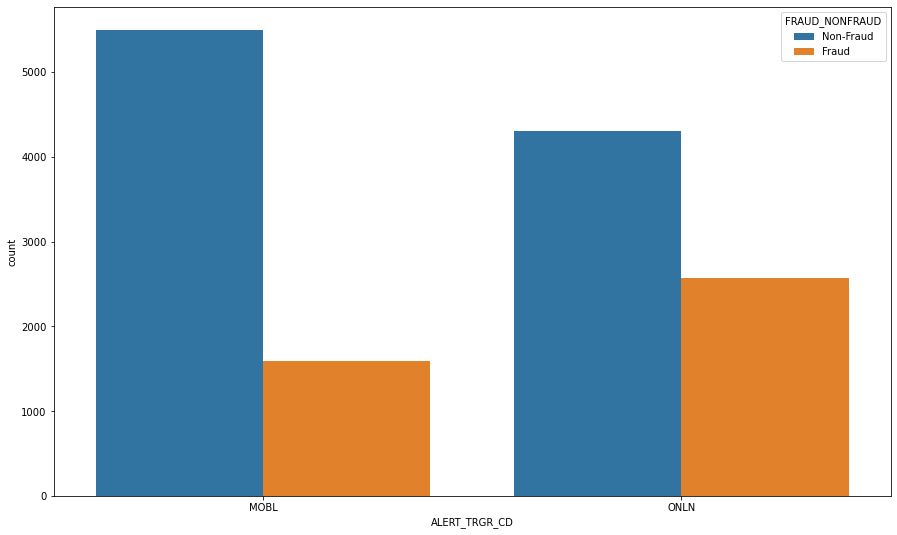

In [129]:


# We can find that in general 20% in Mobl devices and 55% Onln devices are looking out to be Fradualent

plt.figure(figsize=(15,9))
sns.countplot(df['ALERT_TRGR_CD'], hue = df['FRAUD_NONFRAUD'])

<AxesSubplot:xlabel='TRAN_TS', ylabel='count'>

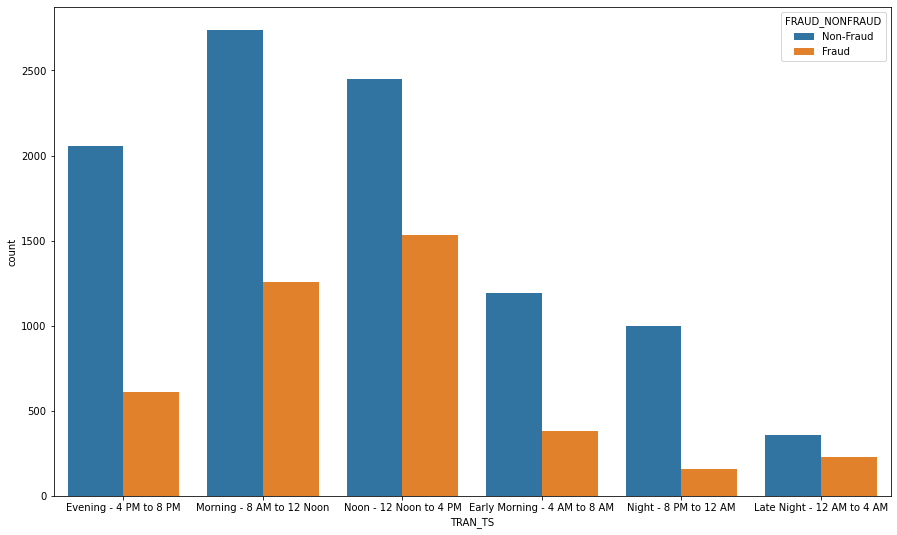

In [130]:
# Understanding the time of the day!4

plt.figure(figsize=(15,9))
sns.countplot(df['TRAN_TS'], hue = df['FRAUD_NONFRAUD'])

In [131]:
df.shape

(13964, 20)

<AxesSubplot:>

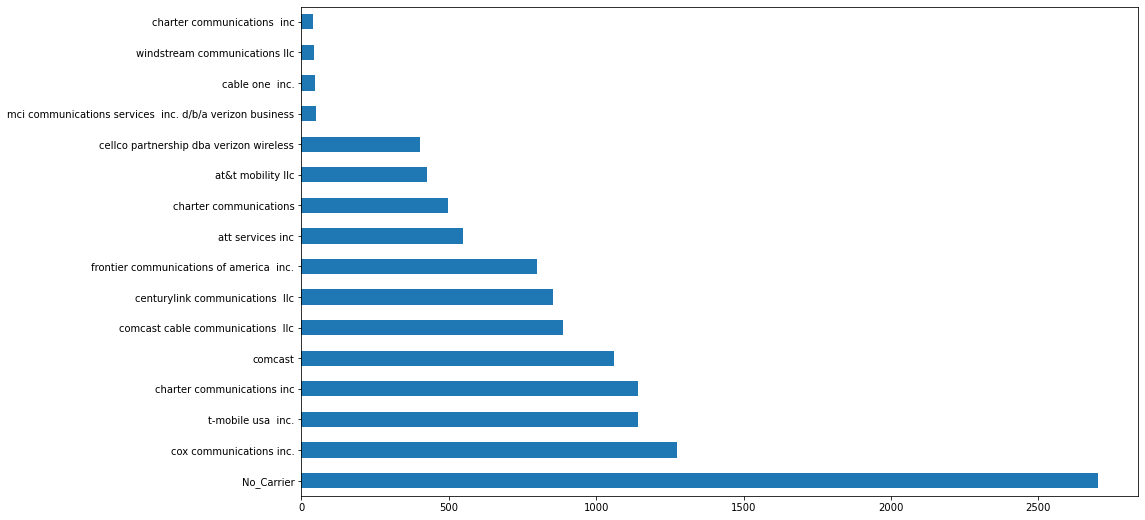

In [132]:
plt.figure(figsize=(15,9))

df['CARR_NAME'].value_counts()[0:16].plot(kind='barh')

### Bivariate Analysis

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

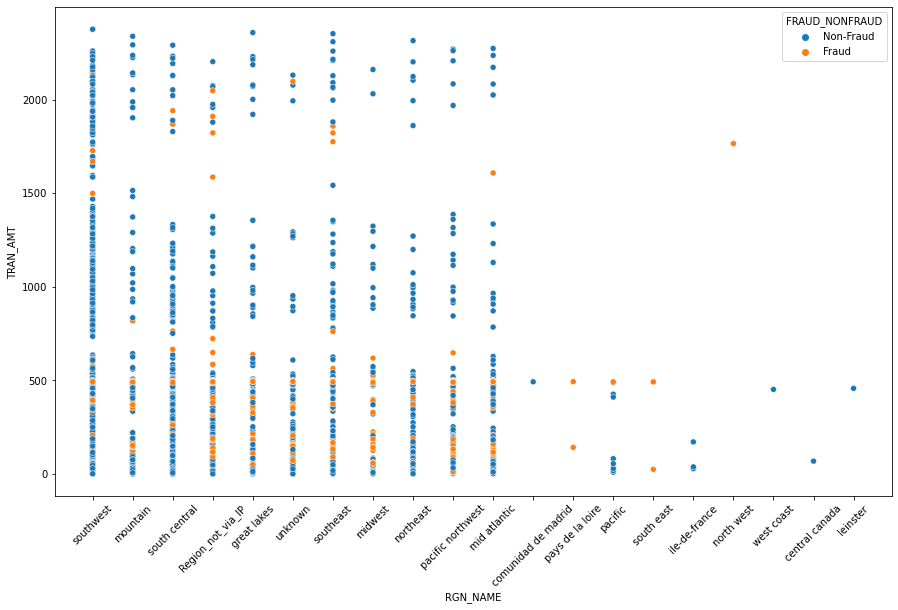

In [133]:
plt.figure(figsize=(15,9))

sns.scatterplot(x = df['RGN_NAME'], y = df['TRAN_AMT'],hue = df['FRAUD_NONFRAUD'] )
plt.xticks(rotation = 45)

> We can obeserve that approximately after 750 usd, the fradulent transactions are rare, we can create a new >750 column and see its correlance.


In [134]:
transaction_amount_below_750 = df['TRAN_AMT']<750


df['TRAN_AMT_BLW_750'] = transaction_amount_below_750.astype(int)

df

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD,CUST_AGE_BINS,TRAN_AMT_BLW_750
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,Evening - 4 PM to 8 PM,2021-05-03,Non-Fraud,40-50,1
1,65.19,0.00,45,5,2721,Not_updated,charter communications,southwest,california,MOBL,FACE_ID,ALLOW,94541,CA,Not_updated,1971-01-07,Evening - 4 PM to 8 PM,2021-01-13,Non-Fraud,40-50,1
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,Morning - 8 AM to 12 Noon,2021-04-08,Fraud,30-40,1
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,Noon - 12 Noon to 4 PM,2021-08-10,Non-Fraud,60-70,1
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,Morning - 8 AM to 12 Noon,2021-06-27,Fraud,80-110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,Not_updated,cellco partnership dba verizon wireless,southwest,california,MOBL,UN_PWD,ALLOW,92503,CA,7/15/2017 6:58:59,2001-06-05,Noon - 12 Noon to 4 PM,2021-03-12,Non-Fraud,50-60,0
13996,114.38,0.00,44,10,272,11/2/2017 4:28:20,t-mobile usa inc.,southwest,california,MOBL,FACE_ID,ALLOW,80478,CO,Not_updated,2010-06-03,Morning - 8 AM to 12 Noon,2021-06-11,Non-Fraud,40-50,1
13997,493.00,2848.63,54,3,517,6/3/2021 19:31:15,att services inc,southwest,california,MOBL,UN_PWD,ALLOW,33579,FL,5/25/2021 8:50:5,1984-10-27,Noon - 12 Noon to 4 PM,2021-05-16,Fraud,50-60,1
13998,491.64,3163.25,21,3,0,3/2/2020 11:34:54,No_Carrier,Region_not_via_IP,State_not_via_IP,ONLN,UN_PWD,ALLOW,91702,CA,Not_updated,2021-03-01,Noon - 12 Noon to 4 PM,2021-05-11,Fraud,20-30,1


<AxesSubplot:xlabel='TRAN_AMT_BLW_750', ylabel='count'>

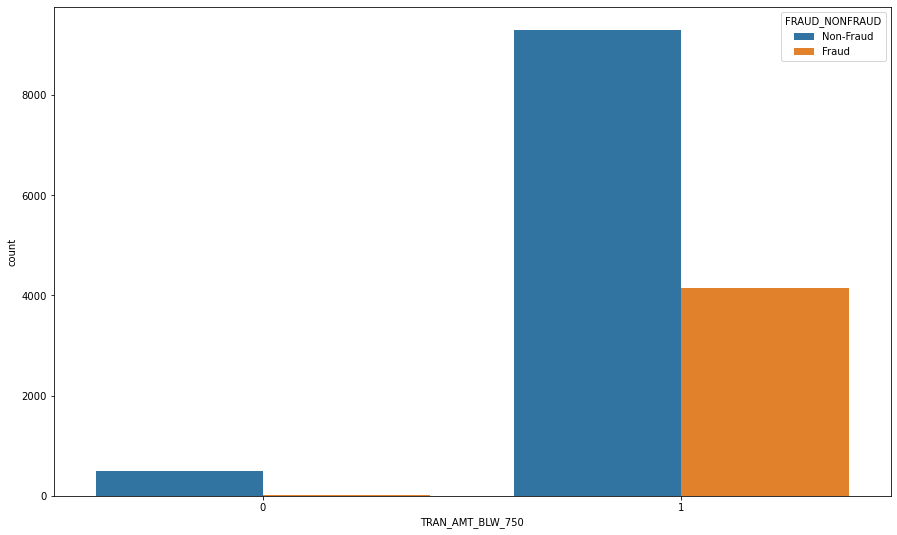

In [135]:
# Understanding the time of the day!4

plt.figure(figsize=(15,9))
sns.countplot(df['TRAN_AMT_BLW_750'], hue = df['FRAUD_NONFRAUD'])

From the above graph we can understand that for transaction amount below $750 USD there is a huge no of Fradulent transactions.

<AxesSubplot:xlabel='CUST_AGE_BINS', ylabel='count'>

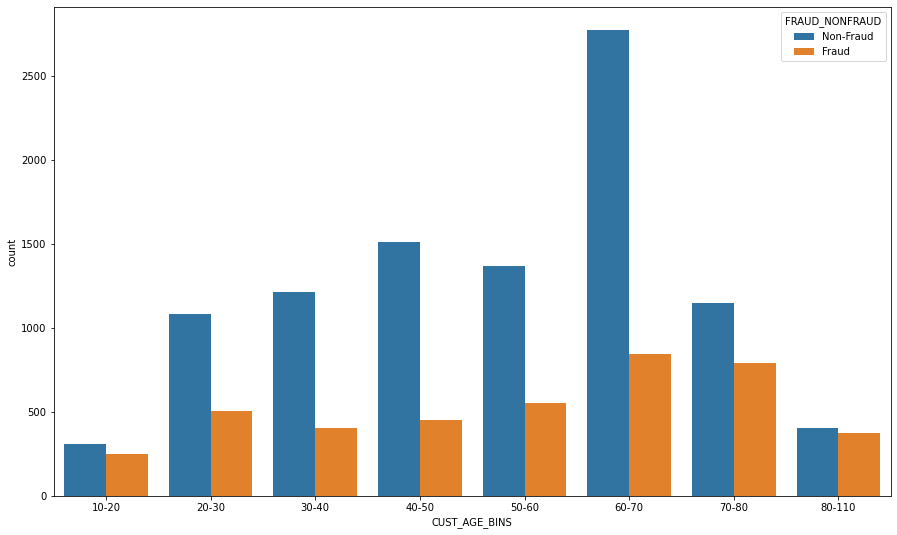

In [136]:
# Understanding the time of the day!4

plt.figure(figsize=(15,9))
sns.countplot(df['CUST_AGE_BINS'], hue = df['FRAUD_NONFRAUD'])

The Fradulent Transactions are mostly similar in every age groups, but the fraud transactions see rise from ages 40-50 and above.

> But the % of transactions are higher in ages 70-80s & 80-110s

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 13964 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  13964 non-null  float64       
 2   CUST_AGE                 13964 non-null  int64         
 3   OPEN_ACCT_CT             13964 non-null  int64         
 4   WF_dvc_age               13964 non-null  int64         
 5   PWD_UPDT_TS              13964 non-null  object        
 6   CARR_NAME                13964 non-null  object        
 7   RGN_NAME                 13964 non-null  object        
 8   STATE_PRVNC_TXT          13964 non-null  object        
 9   ALERT_TRGR_CD            13964 non-null  object        
 10  AUTHC_PRIM_TYPE_CD       13964 non-null  object        
 11  AUTHC_SCNDRY_STAT_TXT    13964 non-null  object        
 12  CUST_ZIP                 13964 n

In [138]:
# label Ecnoding

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['PWD_UPDT_TS'] = le.fit_transform(df['PWD_UPDT_TS'])
df['CARR_NAME'] = le.fit_transform(df['CARR_NAME'])
df['RGN_NAME'] = le.fit_transform(df['RGN_NAME'])
df['ALERT_TRGR_CD'] = le.fit_transform(df['ALERT_TRGR_CD'])
df['AUTHC_PRIM_TYPE_CD'] = le.fit_transform(df['AUTHC_PRIM_TYPE_CD'])
df['AUTHC_SCNDRY_STAT_TXT'] = le.fit_transform(df['AUTHC_SCNDRY_STAT_TXT'])
df['CUST_STATE'] = le.fit_transform(df['CUST_STATE'])
df['PH_NUM_UPDT_TS'] = le.fit_transform(df['PH_NUM_UPDT_TS'])
df['TRAN_TS'] = le.fit_transform(df['TRAN_TS'])
df['TRAN_DT'] = le.fit_transform(df['TRAN_DT'])
df['FRAUD_NONFRAUD'] = le.fit_transform(df['FRAUD_NONFRAUD'])
df['STATE_PRVNC_TXT'] = le.fit_transform(df['STATE_PRVNC_TXT'])
df['CUST_AGE_BINS'] = le.fit_transform(df['CUST_AGE_BINS'])
df['FRAUD_NONFRAUD'] = le.fit_transform(df['FRAUD_NONFRAUD'])


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 13964 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  13964 non-null  float64       
 2   CUST_AGE                 13964 non-null  int64         
 3   OPEN_ACCT_CT             13964 non-null  int64         
 4   WF_dvc_age               13964 non-null  int64         
 5   PWD_UPDT_TS              13964 non-null  int64         
 6   CARR_NAME                13964 non-null  int64         
 7   RGN_NAME                 13964 non-null  int64         
 8   STATE_PRVNC_TXT          13964 non-null  int64         
 9   ALERT_TRGR_CD            13964 non-null  int64         
 10  AUTHC_PRIM_TYPE_CD       13964 non-null  int64         
 11  AUTHC_SCNDRY_STAT_TXT    13964 non-null  int64         
 12  CUST_ZIP                 13964 n

<AxesSubplot:>

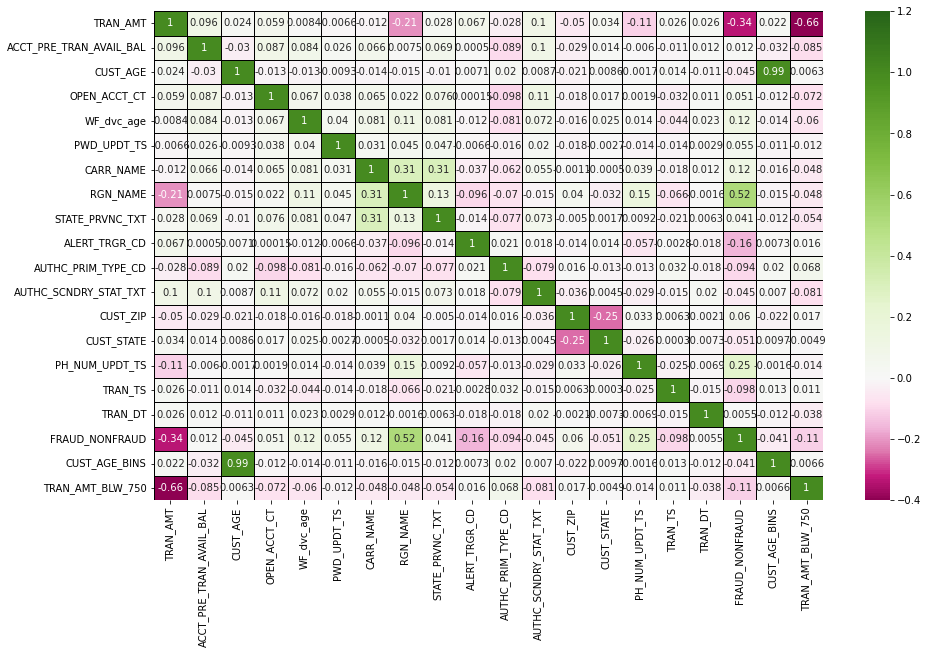

In [140]:

from matplotlib.colors import TwoSlopeNorm


#divnorm is used to put value of zero at centre.
divnorm = TwoSlopeNorm(vmin= -0.4 , vcenter=0, vmax= 1.2)

corr = df.corr()
plt.figure(figsize=(15,9))

sns.heatmap(corr, cmap = 'PiYG', annot = True, norm = divnorm, linewidths=0.7, linecolor='black', cbar=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 13964 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  13964 non-null  float64       
 2   CUST_AGE                 13964 non-null  int64         
 3   OPEN_ACCT_CT             13964 non-null  int64         
 4   WF_dvc_age               13964 non-null  int64         
 5   PWD_UPDT_TS              13964 non-null  int64         
 6   CARR_NAME                13964 non-null  int64         
 7   RGN_NAME                 13964 non-null  int64         
 8   STATE_PRVNC_TXT          13964 non-null  int64         
 9   ALERT_TRGR_CD            13964 non-null  int64         
 10  AUTHC_PRIM_TYPE_CD       13964 non-null  int64         
 11  AUTHC_SCNDRY_STAT_TXT    13964 non-null  int64         
 12  CUST_ZIP                 13964 n

### Model Building

In [142]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FRAUD_NONFRAUD','CUST_SINCE_DT', 'CUST_AGE','ACCT_PRE_TRAN_AVAIL_BAL','OPEN_ACCT_CT', 
                      'PWD_UPDT_TS', 'STATE_PRVNC_TXT', 'TRAN_DT','CUST_AGE_BINS' ] )
y = df['FRAUD_NONFRAUD']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.16,random_state=42)

#Logistic Regression

from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, f1_score

acc_score_lr = accuracy_score(y_test, y_pred)
prec_score_lr = precision_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)

print(f'Accuracy Score - Logistic Regression: {acc_score_lr}')
print(f'Precision Score- Logistic Regression: {prec_score_lr}')
print(f'F1 Score- Logistic Regression: {f1_lr}')

Accuracy Score - Logistic Regression: 0.8076062639821029
Precision Score- Logistic Regression: 0.832171893147503
F1 Score- Logistic Regression: 0.8695388349514563


In [143]:

from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the default parameters)
knc = KNeighborsClassifier()

# fit the model with data
knc.fit(X_train,y_train)

#
y_pred=knc.predict(X_test)

acc_score_knc = accuracy_score(y_test, y_pred)
prec_score_knc = precision_score(y_test, y_pred)
f1_knc = f1_score(y_test, y_pred)

print(f'Accuracy Score - KNN: {acc_score_knc}')
print(f'Precision Score - KNN: {prec_score_knc}')
print(f'F1 Score - KNN: {f1_knc}')

Accuracy Score - KNN: 0.8129753914988814
Precision Score - KNN: 0.8481927710843373
F1 Score - KNN: 0.8707482993197277


In [144]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train,y_train)

#
y_pred=svc.predict(X_test)

acc_score_svc = accuracy_score(y_test, y_pred)
prec_score_svc = precision_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred)

print(f'Accuracy Score - SVC: {acc_score_svc}')
print(f'Precision Score - SVC: {prec_score_svc}')
print(f'F1 Score - SVC: {f1_svc}')

Accuracy Score - SVC: 0.7042505592841163
Precision Score - SVC: 0.7042505592841163
F1 Score - SVC: 0.8264636387503281


In [145]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model (using the default parameters)
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# fit the model with data
dtc.fit(X_train,y_train)

#
y_pred_DT=dtc.predict(X_test)

acc_score_dtc = accuracy_score(y_test, y_pred_DT)
prec_score_dtc = precision_score(y_test, y_pred_DT)
f1_dtc = f1_score(y_test, y_pred_DT)

print(f'Accuracy Score - Decision tree: {acc_score_dtc}')
print(f'Precision Score - Decision tree: {prec_score_dtc}')
print(f'F1 Score - Decision tree: {f1_dtc}')

Accuracy Score - Decision tree: 0.9190156599552572
Precision Score - Decision tree: 0.929143561306223
F1 Score - Decision tree: 0.9433844228964654


Since, *Decision Tree classification* models seems like a best performing one, we are going ahead to understand the confusion matrix using the predicted values from Decision tree classifier.

In [146]:
from sklearn.metrics import confusion_matrix, recall_score

conf_matr_dtc = confusion_matrix(y_test, y_pred_DT)
recall_score_dtc = recall_score(y_test, y_pred_DT)

print(conf_matr_dtc)

[[ 546  115]
 [  66 1508]]


Our model is predicting 546 True Positives [Frauds] & 1508 True Negatives [Non Frauds]